# Homework assignment 4

In [113]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy.signal import detrend
from obspy.signal.detrend import polynomial
from sklearn.metrics import r2_score

## Task 1

In [91]:
df = pd.read_csv("Miles.csv", index_col="DATE", parse_dates=["DATE"])
df

,TRFVOLUSM227NFWA
DATE,
1970-01-01,80173.0
1970-02-01,77442.0
1970-03-01,90223.0
1970-04-01,89956.0
1970-05-01,97972.0
...,...
2023-09-01,278073.0
2023-10-01,284151.0
2023-11-01,265178.0


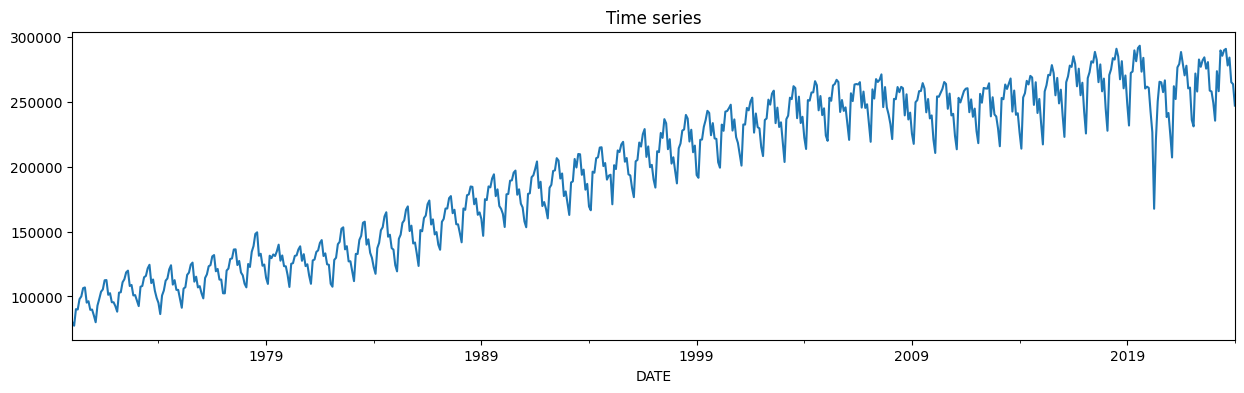

In [92]:
df["TRFVOLUSM227NFWA"].plot(figsize=(15,4))
plt.title("Time series")
plt.show()

## Task 2

## Task 3

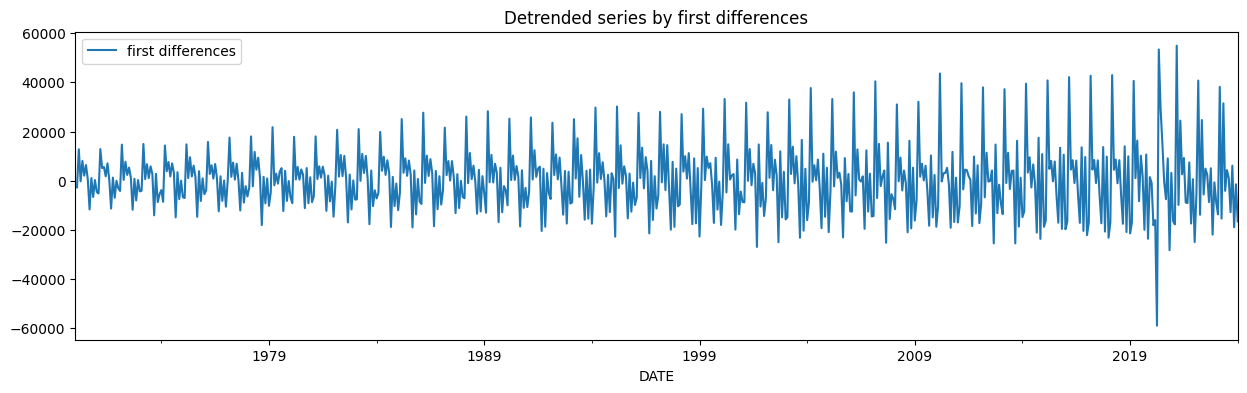

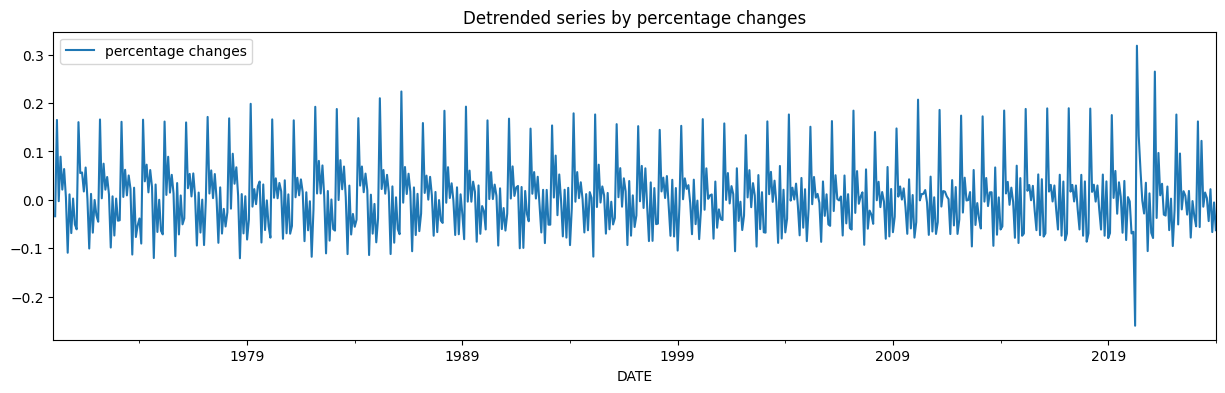

In [93]:
first_diffs = df["TRFVOLUSM227NFWA"].diff(1)
first_diffs.plot(label='first differences', figsize=(15, 4))
plt.title('Detrended series by first differences')
plt.legend()
plt.show()

pct_changes = df['TRFVOLUSM227NFWA'].pct_change()
pct_changes.plot(label='percentage changes', figsize=(15, 4))
plt.title('Detrended series by percentage changes')
plt.legend()
plt.show()

In [94]:
def plot_rolling_stats(window_size: int, series: pd.Series, name: str) -> plt.Axes:
    """
    Plot rolling mean and standard deviation for pandas Series
    """
    series_fd = series.rolling(window_size).mean().plot(label=f"Rolling mean of {name}", figsize=(15, 4))
    series_std = series.rolling(window_size).std().plot(label=f"Rolling standard deviation of {name}", figsize=(15, 4))
    plt.title(f"{name.capitalize()}: rolling mean and standard deviation")
    plt.legend()
    plt.show()

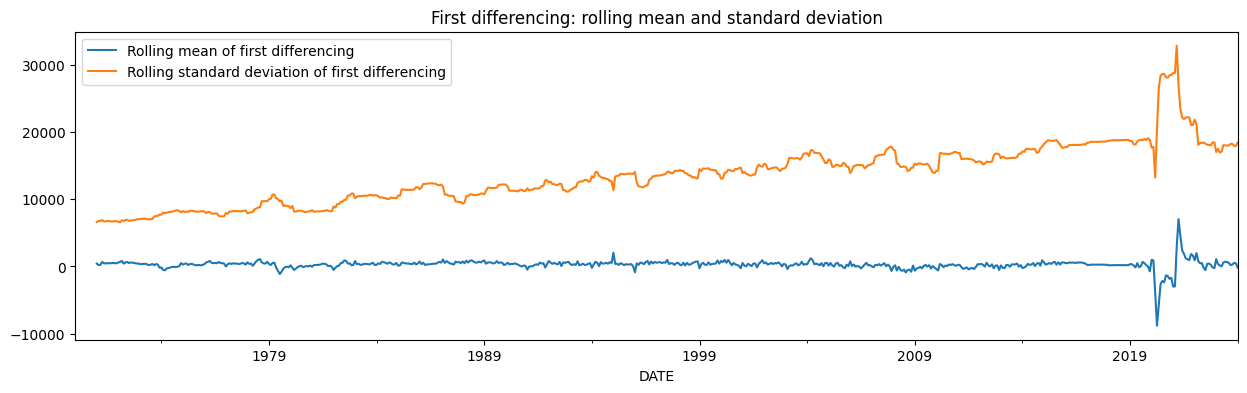

In [95]:
window_size = 12

plot_rolling_stats(window_size, first_diffs, "first differencing")

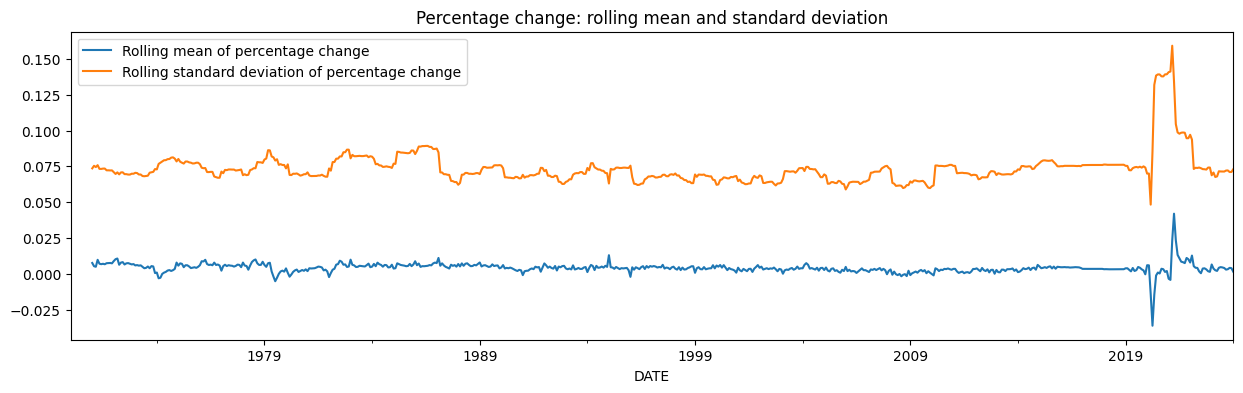

In [96]:
plot_rolling_stats(window_size, pct_changes, "percentage change")

## Task 4

In [97]:
df['TRFVOLUSM227NFWA_log'] = np.log(df['TRFVOLUSM227NFWA'])
df['time_int'] = range(1, df.shape[0] + 1)
df['time_int_square'] = df['time_int'] ** 2
df.head(5)

,TRFVOLUSM227NFWA,TRFVOLUSM227NFWA_log,time_int,time_int_square
DATE,,,,
1970-01-01,80173.0,11.291942,1,1
1970-02-01,77442.0,11.257285,2,4
1970-03-01,90223.0,11.410040,3,9
1970-04-01,89956.0,11.407076,4,16
1970-05-01,97972.0,11.492437,5,25


In [98]:
def get_trend_preds(data, x_names, y_name):
    data = data.dropna()
    model = LinearRegression(fit_intercept=True)
    model.fit(data[x_names], data[y_name])
    trend_preds = model.predict(data[x_names])
    trend_preds = pd.Series(trend_preds, index=data.index)
    return trend_preds

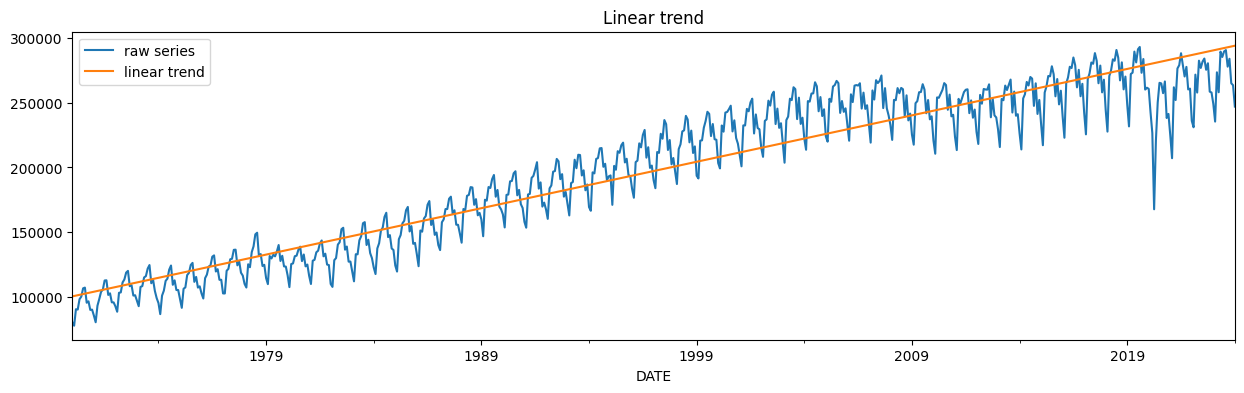

In [99]:
linear_trend = get_trend_preds(data=df.copy(), x_names=['time_int'], y_name='TRFVOLUSM227NFWA')
df['linear_trend'] = linear_trend
df['value_detrended_linearly'] = df['TRFVOLUSM227NFWA'] - df['linear_trend']

df['TRFVOLUSM227NFWA'].plot(label='raw series')
df['linear_trend'].plot(label='linear trend', figsize=(15, 4))
plt.legend()
plt.title('Linear trend')
plt.show()

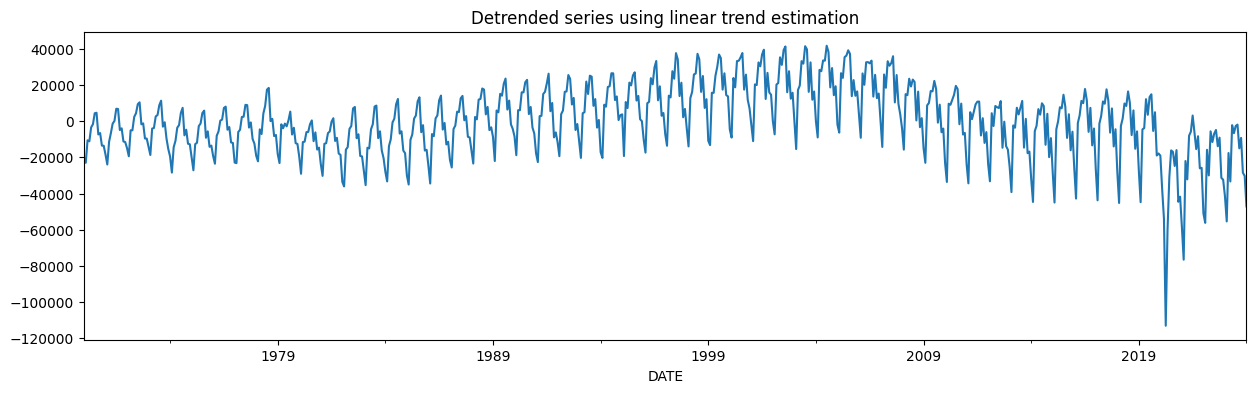

In [100]:
df['value_detrended_linearly'].plot(figsize=(15, 4))
plt.title('Detrended series using linear trend estimation')
plt.show()

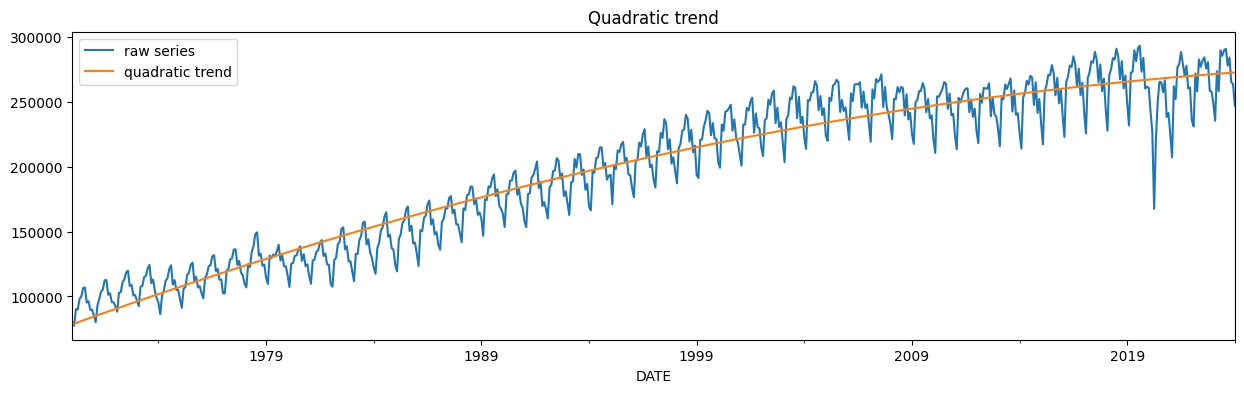

In [101]:
quadratic_trend = get_trend_preds(data=df.copy(), x_names=['time_int', 'time_int_square'], y_name='TRFVOLUSM227NFWA')
df['quadratic_trend'] = quadratic_trend
df['value_detrended_quadratically'] = df['TRFVOLUSM227NFWA'] - df['quadratic_trend']

df['TRFVOLUSM227NFWA'].plot(label='raw series')
df['quadratic_trend'].plot(label='quadratic trend', figsize=(15,4))
plt.legend()
plt.title('Quadratic trend')
plt.show()

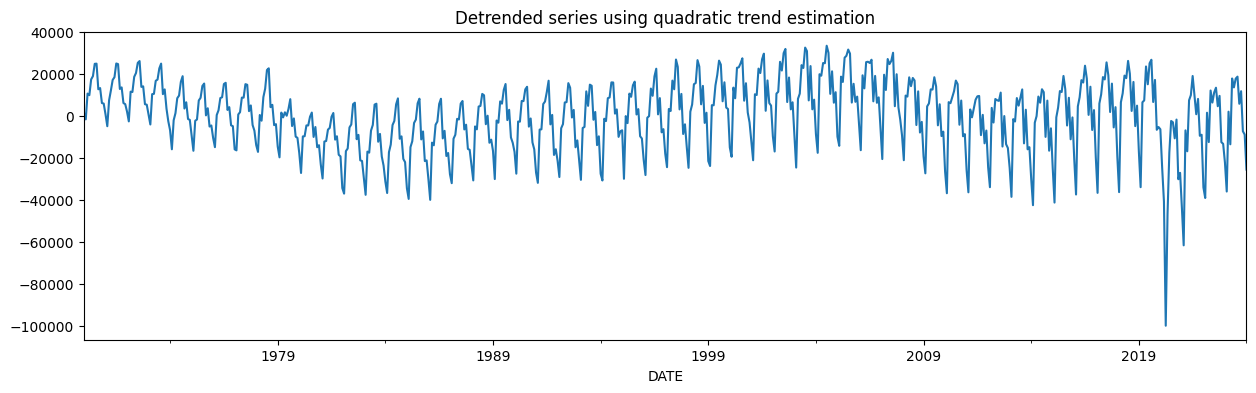

In [102]:
df['value_detrended_quadratically'].plot(figsize=(15, 4))
plt.title('Detrended series using quadratic trend estimation')
plt.show()

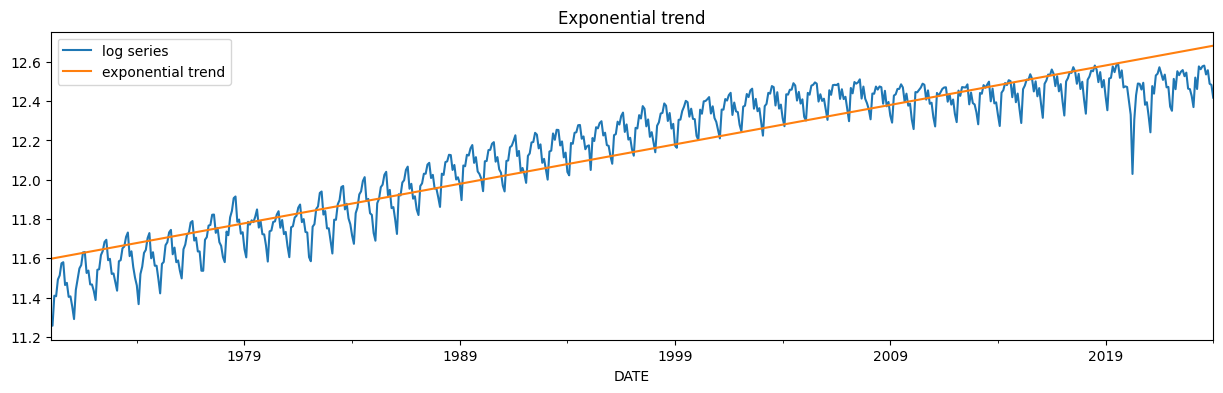

In [103]:
exponential_trend = get_trend_preds(data=df.copy(), x_names=['time_int'], y_name='TRFVOLUSM227NFWA_log')
df['exponential_trend'] = exponential_trend
df['value_log_detrended_exponentially'] = df['TRFVOLUSM227NFWA_log'] - df['exponential_trend']

df['TRFVOLUSM227NFWA_log'].plot(label='log series')
df['exponential_trend'].plot(label='exponential trend', figsize=(15,4))
plt.legend()
plt.title('Exponential trend')
plt.show()

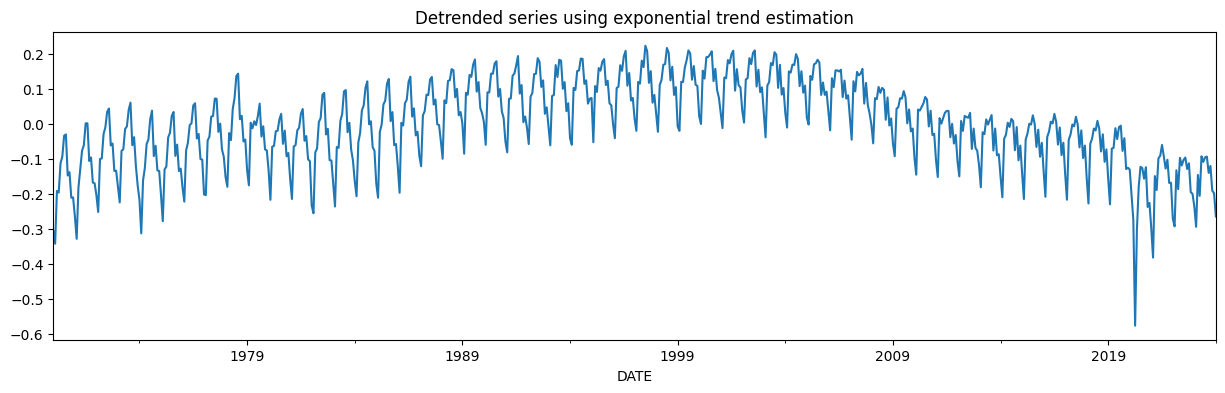

In [104]:
df['value_log_detrended_exponentially'].plot(figsize=(15, 4))
plt.title('Detrended series using exponential trend estimation')
plt.show()

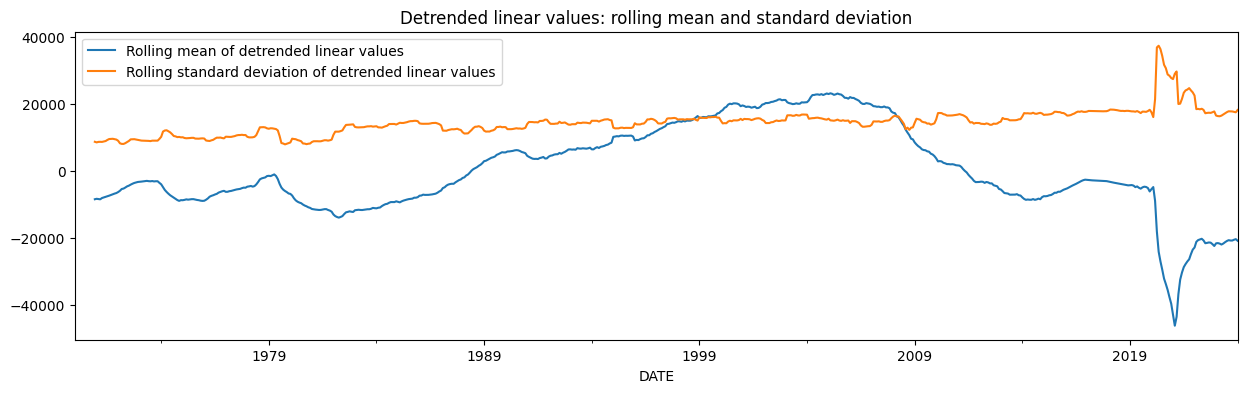

In [105]:
plot_rolling_stats(window_size, df['value_detrended_linearly'], "detrended linear values")

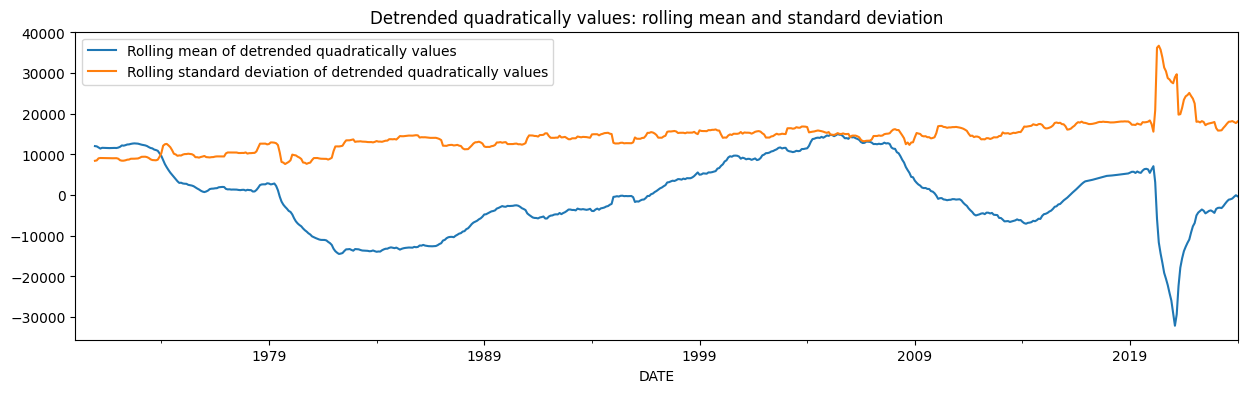

In [106]:
plot_rolling_stats(window_size, df['value_detrended_quadratically'], "detrended quadratically values")

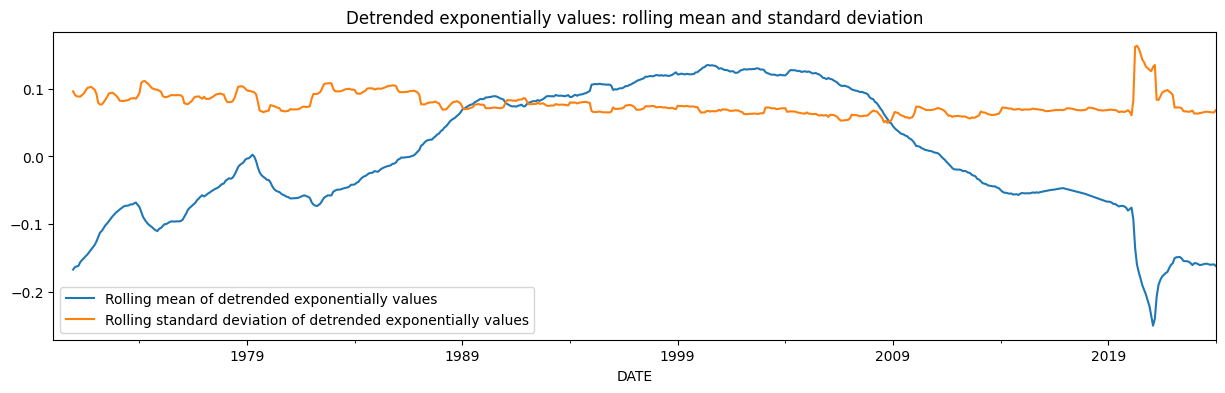

In [107]:
plot_rolling_stats(window_size, df['value_log_detrended_exponentially'], "detrended exponentially values")

## Task 5

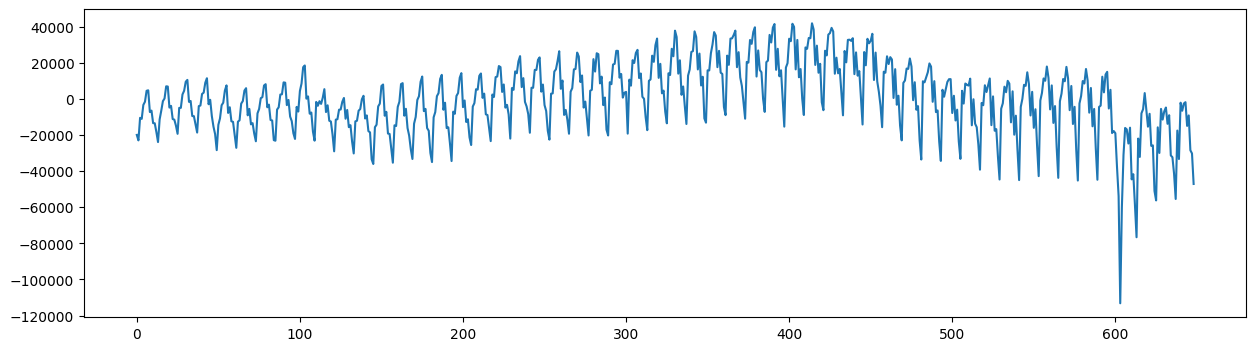

In [108]:
a = detrend(df["TRFVOLUSM227NFWA"].values)

plt.figure(figsize=(15, 4))
plt.plot(a)

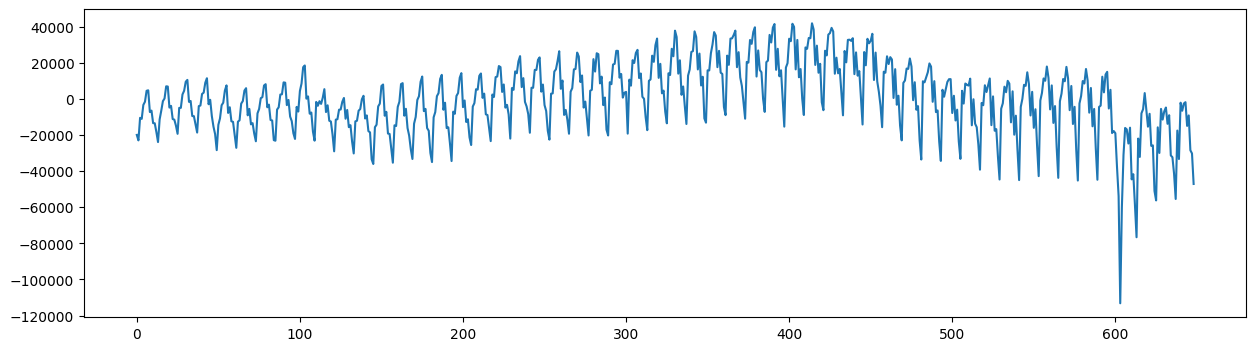

In [114]:
time_series = df["TRFVOLUSM227NFWA"].copy().values

detrended_scp = detrend(time_series)

plt.figure(figsize=(15, 4))
plt.plot(detrended_scp)

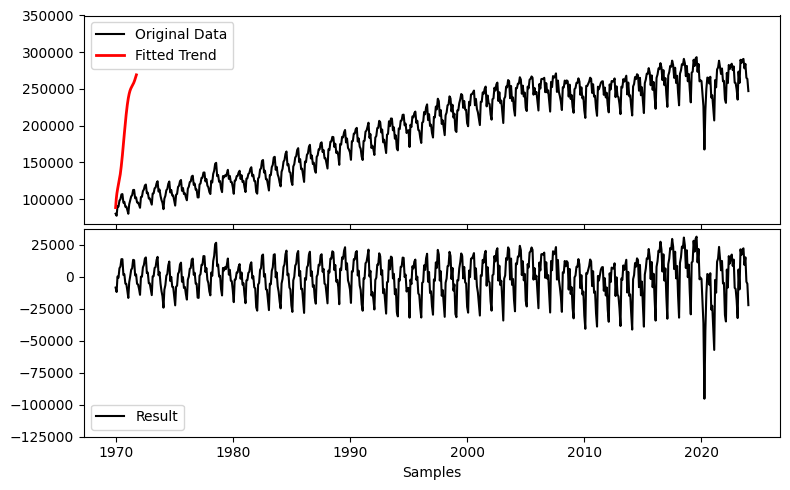

In [156]:
time_series = df["TRFVOLUSM227NFWA"].copy()

detrended = polynomial(time_series, order=6, plot=True)

## Task 6

In [129]:
true_y = df["TRFVOLUSM227NFWA"]

print(r2_score(y_pred=first_diffs.dropna(), y_true=true_y[:true_y.size-1]))
print(r2_score(pct_changes.dropna(), true_y[:true_y.size-1]))
print(r2_score(y_pred=df["linear_trend"], y_true=true_y))
print(r2_score(y_pred=df["quadratic_trend"], y_true=true_y))
print(r2_score(y_pred=df["exponential_trend"], y_true=df["TRFVOLUSM227NFWA_log"]))
print(r2_score(y_pred=detrended, y_true=df["TRFVOLUSM227NFWA"]))

-11.121390228482454
-8351760869734.428
0.8950810225632619
0.9218234352000222
0.8700385970490756
-10.995991840748912


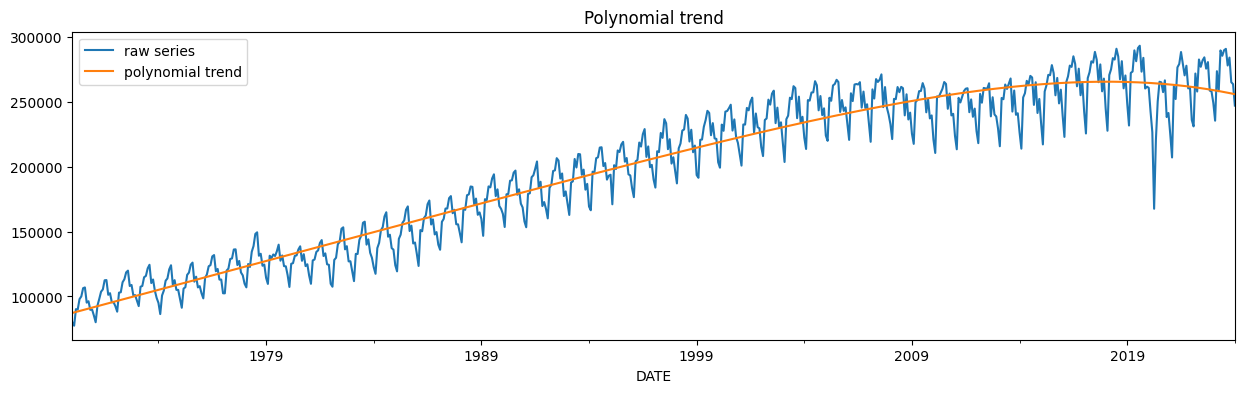

0.927720743571644


In [155]:
df["time_in_4"] = df['time_int'] ** 6
quadratic_trend = get_trend_preds(data=df.copy(), x_names=['time_int', 'time_in_4'], y_name='TRFVOLUSM227NFWA')
df['polynomial_trend'] = quadratic_trend
df['value_detrended_polynomial'] = df['TRFVOLUSM227NFWA'] - df['polynomial_trend']

df['TRFVOLUSM227NFWA'].plot(label='raw series')
df['polynomial_trend'].plot(label='polynomial trend', figsize=(15,4))
plt.legend()
plt.title('Polynomial trend')
plt.show()

print(r2_score(y_pred=df["polynomial_trend"], y_true=true_y))

In [154]:
df.tail()


,TRFVOLUSM227NFWA,TRFVOLUSM227NFWA_log,time_int,time_int_square,linear_trend,value_detrended_linearly,quadratic_trend,value_detrended_quadratically,exponential_trend,value_log_detrended_exponentially,time_in_4,polynomial_trend,value_detrended_polynomial
DATE,,,,,,,,,,,,,
2023-09-01,278073.0,12.535639,645,416025,293071.768077,-14998.768077,272277.497001,5795.502999,12.675132,-0.139493,-8897474214018576723,165808.901573,112264.098427
2023-10-01,284151.0,12.557261,646,417316,293371.309249,-9220.309249,272378.982782,11772.017218,12.676805,-0.119544,-8391093889805474432,167481.149717,116669.850283
2023-11-01,265178.0,12.488157,647,418609,293670.850420,-28492.850420,272479.850606,-7301.850606,12.678478,-0.190321,-7879988437188232585,169169.001917,96008.998083
2023-12-01,263710.0,12.482605,648,419904,293970.391591,-30260.391591,272580.100472,-8870.100472,12.680151,-0.197546,-7364121170622283776,170872.579322,92837.420678
2024-01-01,247129.0,12.417666,649,421201,294269.932763,-47140.932763,272679.732380,-25550.732380,12.681824,-0.264158,-6843455177056897799,172592.003833,74536.996167


## Task 7

In [170]:
def plot_the_interval(series: pd.Series, lower: int, upper: int) -> plt.Axes:
    """
    Plot the specific interval
    """
    series[lower:upper].plot(figsize=(15,4))
    plt.title(f"From {1970 + lower//12} year to {1970 + upper//12} year")

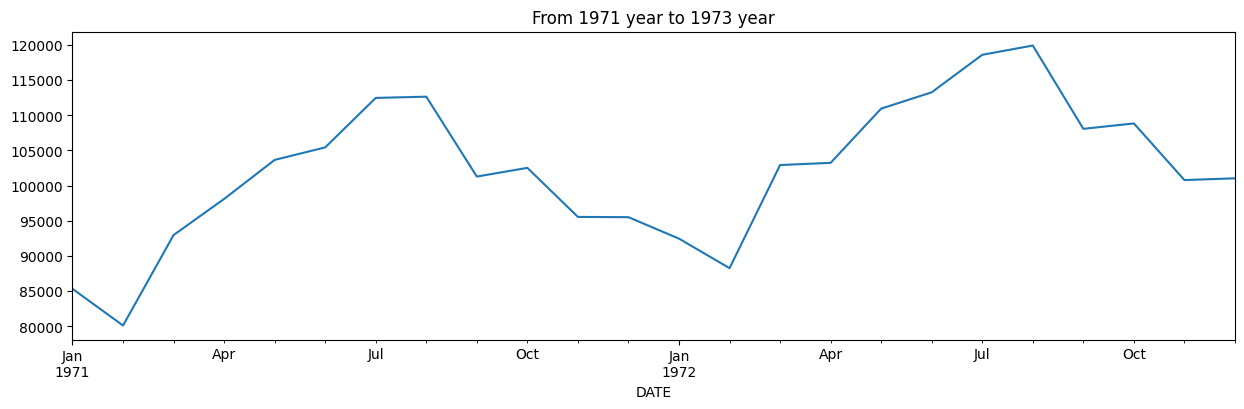

In [171]:
plot_the_interval(df["TRFVOLUSM227NFWA"],12,36)